#### Inspired by the work of:

https://medium.com/@tuennermann/convolutional-neural-networks-to-find-cars-43cbc4fb713

https://github.com/HTuennermann/Vehicle-Detection-and-Tracking

https://github.com/heuritech/convnets-keras

https://github.com/maxritter/SDC-Vehicle-Lane-Detection


#### 1. Config
This cell:
* Defines configuration variables for this IPython notebook.

In [1]:
# Visualisation parameters
display_output = 1
train_verbose_style = 2  # 1 every training image, 2 once very epoch

# Training parameters
use_generator = 0
epoch_num = 30
train_model = 1

#### 2. Project 5 data set import

This cell:
* Creates a feature file name list of the car/non-car supplied files
* Creates a label (y) vector
* Randomly split the dataset into a train and a validation dataset

In [2]:
import glob
import numpy as np
from sklearn.model_selection import train_test_split

cars = glob.glob("./dataset/vehicles/*/*.png")
non_cars = glob.glob("./dataset/non-vehicles/*/*.png")

# feature list
X = []

# Append cars and non-cars image file paths to the feature list
for car in cars:
    X.append(car)

for non_car in non_cars:
    X.append(non_car)
    
X = np.array(X)

# Generate y Vector (Cars = 1, Non-Cars = -1)
y = np.concatenate([np.ones(len(cars)), np.zeros(len(non_cars))-1])

# Randomly split the file paths in a validation set and a training set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

print("Loading done!")

Loading done!


#### 3. Print a dataset summary
This cell:
* Prints a summary of the dataset

In [3]:
import matplotlib.image as mpimg
%matplotlib inline

if display_output == 1:
    # Load the 1rst image to get its size
    train_img = mpimg.imread(X_train[0])

    # Dataset image shape
    image_shape = train_img.shape

    # Number of unique classes/labels there are in the dataset.
    n_classes = np.unique(y_train).size

    print("Number of training examples =", X_train.shape[0])
    print("Number of validation examples =", X_valid.shape[0])
    print("Image data shape =", image_shape)
    print("Number of classes =", n_classes)

Number of training examples = 15984
Number of validation examples = 1776
Image data shape = (64, 64, 3)
Number of classes = 2


#### 4. Exploratory visualization of the dataset

This cell:
* Defines the `show_dataset_classes_histogram` function
* Defines the `show_sample()` function
* Shows an hstogram distribution of the dataset classes
* Shows a random sample of the dataset

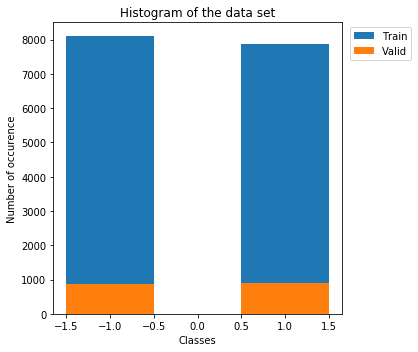

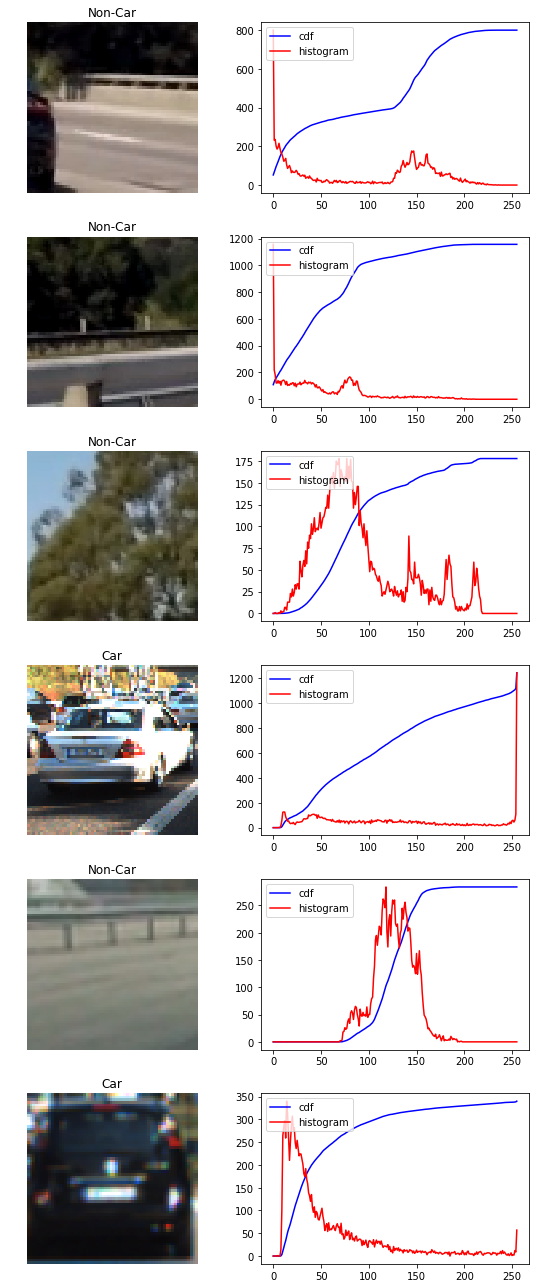

In [4]:
import matplotlib.pyplot as plt
import random


def show_dataset_classes_histogram(labels_train, labels_valid):
    f, ax = plt.subplots(figsize=(5, 5))

    # Generate histogram and bins
    hist_train, bins = np.histogram(labels_train, 2)
    hist_valid, bins = np.histogram(labels_valid, 2)

    # Bar width
    width = 1.0 * (bins[1] - bins[0])

    ax.bar([-1, 1], hist_train, width=width, label="Train")
    ax.bar([-1, 1], hist_valid, width=width, label="Valid")

    ax.set_xlabel('Classes')
    ax.set_ylabel('Number of occurence')
    ax.set_title('Histogram of the data set')

    ax.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
    f.tight_layout()
    
    plt.savefig("./output_images/histogram_dataset.png")


def show_sample(features, labels, preprocess=0, sample_num=1, sample_index=-1):
    col_num = 2
    # Create training sample + histogram plot
    f, axarr = plt.subplots(sample_num, col_num, figsize=(col_num * 4, sample_num * 3))

    index = sample_index - 1
    for i in range(0, sample_num, 1):

        if sample_index == -1:
            index = random.randint(0, len(features))
        else:
            index = index + 1

        if labels[index] == 1:
            label_str = "Car"
        else:
            label_str = "Non-Car"

        image = (mpimg.imread(features[index]) * 255).astype(np.uint8)

        if preprocess == 1:
            image = image_preprocessing(image)

        axarr[i, 0].set_title('%s' % label_str)
        axarr[i, 0].imshow(image)

        hist, bins = np.histogram(image.flatten(), 256, [0, 256])
        cdf = hist.cumsum()
        cdf_normalized = cdf * hist.max()/ cdf.max()

        axarr[i, 1].plot(cdf_normalized, color='b')
        axarr[i, 1].plot(hist, color='r')
        axarr[i, 1].legend(('cdf', 'histogram'), loc='upper left')

        axarr[i, 0].axis('off')

    # Tweak spacing to prevent clipping of title labels
    f.tight_layout()

    if preprocess == 1:
        plt.savefig("./output_images/dataset_sample_preprocessed.png")
    else:
        plt.savefig("./output_images/dataset_sample.png")

    
if display_output == 1:
    show_dataset_classes_histogram(y_train, y_valid)
    show_sample(X_train, y_train, sample_num=6, sample_index=110)

#### 5. Get Model

As we have seen in the "intro to convolutionnal network" lesson, a nice property of a convolutional filter is that is reuses the weights gwhile slidding through the image and feature maps, the weight number is thus not dependent on the input image size. Therefore, it is possible to train a full ConvNet to classify small size images (64x64) as an image classifier (like we have done for Project 2) and output the result on one neuron. 

In our case the output will be either there is a car in the image or not (tanh=1 or tanh=-1). The weights resulting from the training can then be reused on the same full ConvNet to build an output feature map from larger images. This feature map can be seen as a heatmap in which each pixel represents the output of the original trained ConvNet for a section of the input image. These pixels thus give the "car probability" for a specific location in the input image.

This cell:
* Gets an all convolutionnal Keras model to train from the file *model.py*. 

In [5]:
from model import get_model
from keras.layers import Flatten

# Get the "base" ConvNet Model
model = get_model()

# Flat out the last layer for training
model.add(Flatten())

# Print out model summary
if display_output == 1:
    model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 50)        1400      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 50)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 50)        22550     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 64, 50)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 50)        22550     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 50)          0         
__________

#### 6. Declare generators/load dataset

This cell:
* Declares a Keras generator (`keras_generator()`) to enable training on low end hardware
* Declares a loader (`loader()`) to load all the dataset in memory (faster training, higher end hardware required)

In [6]:
from sklearn.utils import shuffle


def keras_generator(features, labels, batch_size=32):
    num_features = len(features)
    # Loop forever so the generator never terminates
    while 1:
        # shuffles the input sample
        shuffle(features, labels)
        for offset in range(0, num_features, batch_size):
            # File path subset
            batch_features = features[offset:offset + batch_size]
            batch_labels = labels[offset:offset + batch_size]
            imgs = []

            for feature in batch_features:
                image = (mpimg.imread(feature) * 255).astype(np.uint8)

                # Image preprocessing
                # none..
                imgs.append(image)

            # Convert images to numpy arrays
            X = np.array(imgs, dtype=np.uint8)
            y = np.array(batch_labels)

            yield shuffle(X, y)


def loader(features, labels):
    for iterable in keras_generator(features, labels, batch_size=len(features)):
        return iterable


# Prepare generator functions /dataset
if use_generator == 1:
    # Use the generator function
    train_generator =      keras_generator(X_train, y_train, batch_size=32)
    validation_generator = keras_generator(X_valid, y_valid, batch_size=32)
else:
    # Load all the preprocessed images in memory
    train_set =      loader(X_train, y_train)
    validation_set = loader(X_valid, y_valid)

#### 7. Train Model and save the best weights

This cell:
* Defines a training visualization function (`plot_train_result()`)
* Compiles the Keras model. The Adam optimizer is chosen and Mean Squared Error is used as a loss function
* A Keras checkpointer is declared and configured to save the weights if loss becomes lower than the lowest loss to date. The checkpointer is called via the callback parameter and is exucuted after each epoch.
* Trains the model either with a generator or not.
* Outputs a figure of the Training/Validation accuracy vs the epochs.

/home/deep/miniconda2/envs/carnd-term1-gpu/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:2252: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Train on 15984 samples, validate on 1776 samples
Epoch 1/30
Epoch 00000: val_loss improved from inf to 0.13951, saving model to ./weights/best-weights.hdf5
9s - loss: 0.4150 - acc: 0.6372 - val_loss: 0.1395 - val_acc: 0.9206
Epoch 2/30
Epoch 00001: val_loss did not improve
8s - loss: 0.1096 - acc: 0.9282 - val_loss: 0.1441 - val_acc: 0.9139
Epoch 3/30
Epoch 00002: val_loss improved from 0.13951 to 0.09365, saving model to ./weights/best-weights.hdf5
8s - loss: 0.0733 - acc: 0.9526 - val_loss: 0.0936 - val_acc: 0.9381
Epoch 4/30
Epoch 00003: val_loss improved from 0.09365 to 0.05428, saving model to ./weights/best-weights.hdf5
8s - loss: 0.0603 - acc: 0.9641 - val_loss: 0.0543 - val_acc: 0.9679
Epoch 5/30
Epoch 00004: val_loss did not improve
8s - loss: 0.0478 - acc: 0.9729 - val_loss: 0.0729 - val_acc: 0.9657
Epoch 6/30
Epoch 00005: val_loss did not improve
8s - loss: 0.0456 - acc: 0.9758 - val_loss: 0.0655 - val_acc: 0.9668
Epoch 7/30
Epoch 00006: val_loss did not improve
8s - loss: 0

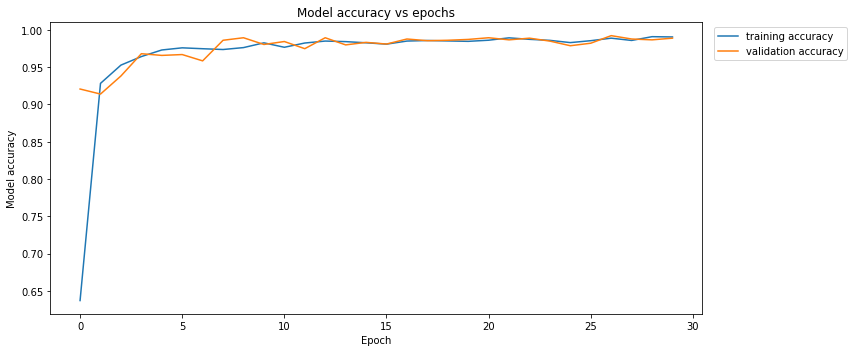

In [7]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam


def plot_train_results(history_object):
    f, ax = plt.subplots(figsize=(10, 5))
    ax.plot(history_object.history['acc'])
    ax.plot(history_object.history['val_acc'])
    ax.set_ylabel('Model accuracy')
    ax.set_xlabel('Epoch')
    ax.set_title('Model accuracy vs epochs')
    plt.legend(['training accuracy', 'validation accuracy'], bbox_to_anchor=(1.01, 1.0))

    f.tight_layout()
    plt.savefig("./output_images/accuracy_over_epochs.png")


if train_model == 1:
    # Compile the model using an Adam optimizer
    model.compile(optimizer=Adam(), loss='mse', metrics=['accuracy'])

    # saves the model weights after each epoch if the validation loss decreased
    filepath = './weights/best-weights.hdf5'
    checkpointer = ModelCheckpoint(filepath=filepath,
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   mode='min')

    # Train the model, with or without a generator
    if use_generator == 1:
        history_object = model.fit_generator(train_generator,
                                             steps_per_epoch=len(X_train),
                                             epochs=epoch_num,
                                             verbose=train_verbose_style,
                                             callbacks=[checkpointer],
                                             validation_data=validation_generator,
                                             validation_steps=len(X_valid))

    else:
        history_object = model.fit(train_set[0],
                                   train_set[1],
                                   batch_size=64,
                                   epochs=epoch_num,
                                   verbose=train_verbose_style,
                                   callbacks=[checkpointer],
                                   validation_data=(validation_set[0], validation_set[1]))
    
    if display_output == 1:
        plot_train_results(history_object)

## Testing the classifier

#### 8. Load weights

This cell:
* Loads the best weight saved by the Keras checkpointer (code cell #7 above).

In [8]:
# Load the weight
model.load_weights('./weights/best-weights.hdf5')
print("Weights loaded!")

Weights loaded!


#### 9. Test the classifier on random images

This cell:
* Picks random images from the dataset
* Infers the label using the trained model
* Measures the inference time
* Shows a figure of the images and predicted label, title color changes according to correctness of the inference (green = correct, red = incorrect).

/home/deep/miniconda2/envs/carnd-term1-gpu/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:2252: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Image  0 inference time : 0.0263 s
Image  1 inference time : 0.0008 s
Image  2 inference time : 0.0008 s
Image  3 inference time : 0.0008 s
Image  4 inference time : 0.0008 s
Image  5 inference time : 0.0008 s
Image  6 inference time : 0.0008 s
Image  7 inference time : 0.0008 s
Image  8 inference time : 0.0008 s
Image  9 inference time : 0.0008 s
Image 10 inference time : 0.0007 s
Image 11 inference time : 0.0007 s


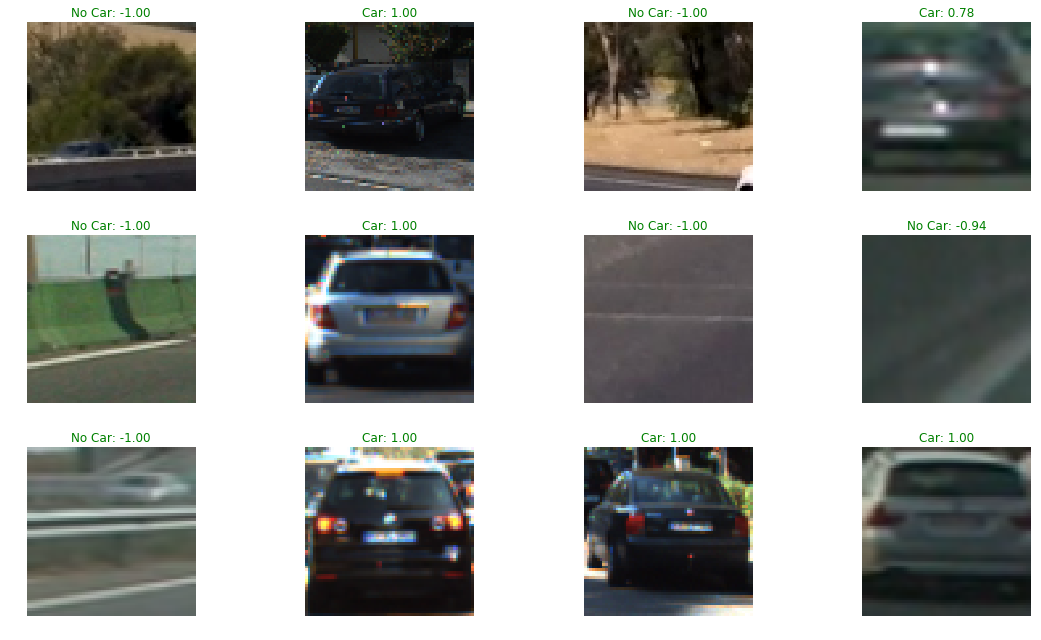

In [9]:
if display_output == 1:

    import matplotlib.pyplot as plt
    %matplotlib inline
    import time
    import numpy as np
    
    sample_num = 12
    
    col_num = 4
    row_num = int(sample_num/col_num)
    
    # Create training sample + histogram plot
    f, axarr = plt.subplots(row_num, col_num, figsize=(col_num * 4, row_num * 3))
    
    for i in range(sample_num):
        
        # Pick a random image from the validation set
        index = np.random.randint(validation_set[0].shape[0])

        # Add one dimension to the image to fit the CNN input shape...
        sample = np.reshape(validation_set[0][index], (1, 64,64,3))
        
        # Record starting time
        start_time = time.time()
        
        # Infer the label
        inference = model.predict(sample, batch_size=64, verbose=0)
        
        # Print time difference...
        print("Image %2d inference time : %.4f s" % (i, time.time() - start_time))
        
        # Extract inference value
        inference = inference[0][0]

        # Show the image
        color_str = 'green'
        if inference >= 0.0:
            title_str = "Car: {:4.2f}" .format(inference)
            if validation_set[1][index] != 1:
                color_str = 'red'            
        else:
            title_str = "No Car: {:4.2f}" .format(inference)
            
            if validation_set[1][index] != -1:
                color_str = 'red'
       
        axarr[int(i/col_num), i % col_num].imshow(validation_set[0][index])
        axarr[int(i/col_num), i % col_num].set_title(title_str, color = color_str)
        axarr[int(i/col_num), i % col_num].axis('off')
        
    f.tight_layout()
    plt.savefig("./output_images/inference.png")